# Tarea 3

Autor : Francisco Herrera Barajas

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Con los datos de este ejemplo crea una red neuronal que sea capaz de generar un error de cero (es decir, la linea de MLP atraviesa todos los puntos).

### **Importamos** paquetes

In [7]:
# Paquetes
import numpy as np
import matplotlib.pyplot as plt
import torch
import sklearn
import seaborn as sns

Cargamos numpy para la creación de arrays.
Torch la utilizaremos para la creación de la red neuronal y para convertir los datos en tensores. Finalmente sklearn nos servira para realizar la regresión lineal.

### Cojemos las coordenadas de los puntos que van generar una curva

In [8]:
X = np.array(
    [258.0, 270.0, 294.0, 320.0, 342.0, 368.0, 396.0, 446.0, 480.0, 586.0]
)[:, np.newaxis] # Utilizamos np.newaxis para convertir este array en uno de dos dimensiones como espera sklearn

y = np.array(
    [236.4, 234.4, 252.8, 298.6, 314.2, 342.2, 360.8, 368.0, 391.2, 390.8]
)

print(X)
print(y)

[[258.]
 [270.]
 [294.]
 [320.]
 [342.]
 [368.]
 [396.]
 [446.]
 [480.]
 [586.]]
[236.4 234.4 252.8 298.6 314.2 342.2 360.8 368.  391.2 390.8]


### Visualizamos los puntos

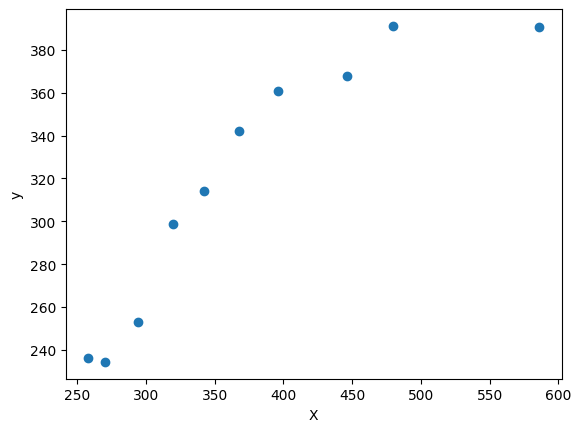

In [9]:
plt.scatter(X, y)
plt.xlabel("X")
plt.ylabel("y")
plt.show()

### Ajustamos un modelo de regresión lineal con los datos.

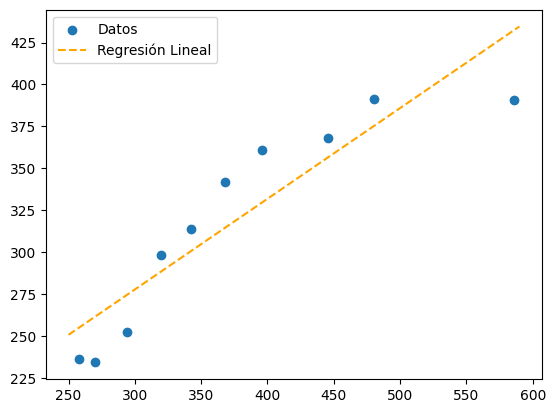

In [10]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression() # Instanciamos el modelo
lr.fit(X, y) # Entrenamos el modelo

X_range = np.arange(250, 600, 10)[:, np.newaxis] # Generamos un vector de números para visualizar la recta de regresión.
y_linear = lr.predict(X_range) # A partir del vector anterior generamos una recta de regresión entrenada con los datos.

# Dibujamos tanto los puntos de los datos como la recta

plt.scatter(X, y, label="Datos")
plt.plot(X_range, y_linear, label="Regresión Lineal", linestyle="--", color="orange")
plt.legend()
plt.show()

Vemos que el modelo de regresión predice bastante bien la disposición de los datos.

### Preparamos los datos para pasarselos a la red

In [11]:
from torch.utils.data import TensorDataset, DataLoader # Cargamos los paquetes para crear un Dataset y un dataloader para carga la red.

# Normalizamos X e y
x_mean, x_std = X.mean(), X.std()
y_mean, y_std = y.mean(), y.std()

X_norm = (X - x_mean) / x_std
y_norm = (y - y_mean) / y_std

# Pasamos las variables a tensores
tensor_X = torch.Tensor(X_norm)
tensor_y = torch.Tensor(y_norm)

# Creamos el dataset y el dataloader
my_dataset = TensorDataset(tensor_X,tensor_y)
my_dataloader = DataLoader(my_dataset)

### Definimos la red

Va ser una red neuronal multicapa clásica con 3 capas. La función de activación que vamos a usar es la función ReLU.

In [12]:
class MLP(torch.nn.Module):
    def __init__(self, X_nvars):
        super().__init__()

        self.layers = torch.nn.Sequential(

            # Hidden Layer 1
            torch.nn.Linear(X_nvars, 10), # Hacemos el sumatorio y damos diez sálidas
            torch.nn.ReLU(),              # Aplicamos la función de activacion

            # Hidden Layer 2

            torch.nn.Linear(10, 5), # Hacemos el sumatorio de las 10 sálidas anteriores y damos 5 nuevas salidas
            torch.nn.ReLU(),              # Aplicamos la función de activacion

            # output layer
            torch.nn.Linear(5, 1), # Esta última capa hace el sumatorio de las 5 últimas salidas y da una única salida que sera el valor que prediga la red.
        )

    def forward(self, x):
        output = self.layers(x)
        return output

Instanciamos el modelo y defínimos la función de pérdida, algoritmo de aprendizaje y la tasa de aprendizaje que vamos a usar.

In [13]:
# Fijamos la semilla a un valor para que los resultados sean identicos
torch.manual_seed(1)

# Creamos el modelo MLP
model = MLP(X_nvars=1)

# Definimos la función loss
loss_fn = torch.nn.MSELoss() # Utilizaremos el error absoluto medio como función de error.

# Ahora el hiper-parámetro de la tasa de aprendizaje y el algortimo de optimización

# Elegimos el optimizador
optimizer = torch.optim.SGD(model.parameters(), lr=0.03) # Optimizador SGD

### Entrenamiento

In [14]:
import torch.nn.functional as F

# Fijamos el número de épocas o iteraciones.
num_epochs = 200

# Instanciamos una lista donde vamos a ir guardando los valores del loss para plotearlos despues y ver como aprende la red.
loss_history = []

# Bucle del entrenamiento
for epoch in range(num_epochs):
    model = model.train() # Instanciamos el modelo en modo entrenamiento.

    for batch_idx, (features, targets) in enumerate(my_dataloader): # Recorremos el conjunto en batches, en nuestro caso solo tenemos un batch.
    # Las targets son las X, las features son las y verdaderas

        output = model(features)            # Hacemos el forward (Pasamos las x por el modelo y obtenemos las predicciones, los output)
        loss = loss_fn(output, targets)     # Calculamos el loss comparando las prediciones con los valores reales de los target.

        optimizer.zero_grad()        # Ponemos a cero el gradiente
        loss.backward()              # Calculamos los gradientes (la derivada del loss)
        optimizer.step()             # Cambiamos los pesos de la red

        # Cada cierto tiempo vamos a imprimir un poco de información: la época y el train loss (MSE).
        if not batch_idx % 100:
            print(
                f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
                f" | Train Loss: {loss.item():.3f}"
            )

     # añadimos el loss a loss_history
    loss_history.append(loss.item())

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 001/200 | Train Loss: 0.786
Epoch: 002/200 | Train Loss: 1.326
Epoch: 003/200 | Train Loss: 1.179
Epoch: 004/200 | Train Loss: 0.655
Epoch: 005/200 | Train Loss: 0.280
Epoch: 006/200 | Train Loss: 0.100
Epoch: 007/200 | Train Loss: 0.037
Epoch: 008/200 | Train Loss: 0.011
Epoch: 009/200 | Train Loss: 0.002
Epoch: 010/200 | Train Loss: 0.000
Epoch: 011/200 | Train Loss: 0.001
Epoch: 012/200 | Train Loss: 0.002
Epoch: 013/200 | Train Loss: 0.003
Epoch: 014/200 | Train Loss: 0.005
Epoch: 015/200 | Train Loss: 0.006
Epoch: 016/200 | Train Loss: 0.007
Epoch: 017/200 | Train Loss: 0.009
Epoch: 018/200 | Train Loss: 0.010
Epoch: 019/200 | Train Loss: 0.010
Epoch: 020/200 | Train Loss: 0.011
Epoch: 021/200 | Train Loss: 0.011
Epoch: 022/200 | Train Loss: 0.011
Epoch: 023/200 | Train Loss: 0.011
Epoch: 024/200 | Train Loss: 0.011
Epoch: 025/200 | Train Loss: 0.011
Epoch: 026/200 | Train Loss: 0.011
Epoch: 027/200 | Train Loss: 0.011
Epoch: 028/200 | Train Loss: 0.010
Epoch: 029/200 | Tra

### Gráfica de la función de pérdida

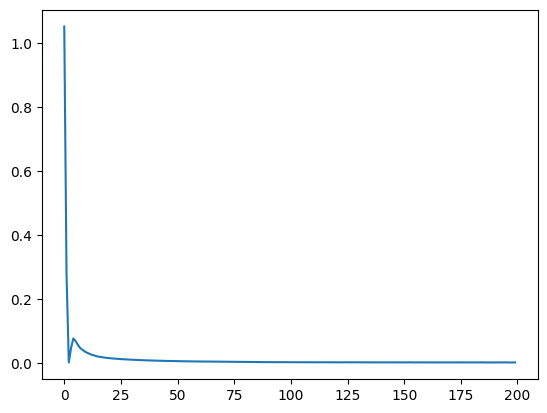

In [15]:
plt.plot(loss_history)

### Evaluación del modelo

In [16]:
# Vamos a evaluar el funcionamiento del modelo

model.eval()

# predecimos los valores del rango X_range segun el MLP

# Se pasan a un tensor normalizado
X_range_norm = (X_range - x_mean) / x_std
X_range_norm = torch.tensor(X_range_norm, dtype=torch.float32)

# Se meten en el modelo
y_mlp_norm = model(X_range_norm)

# Ahora se desnormalizan para que estén en la misma escala
y_mlp_norm = y_mlp_norm.detach().numpy().astype(np.float64) # dejan de ser un tensor
y_mlp = y_mlp_norm * y_std + y_mean # desnormalizan


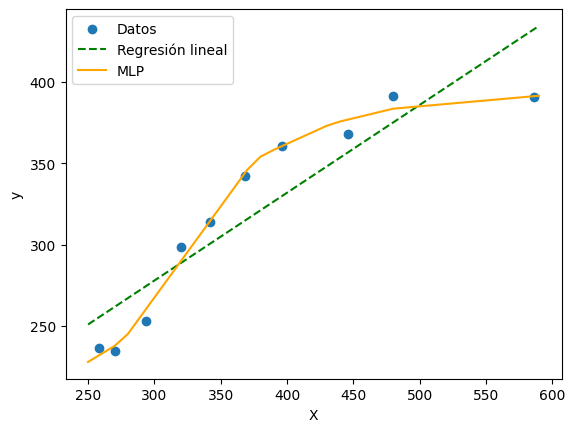

In [17]:
# Vamos a hacer un plot con los resultados

# Los datos originales
plt.scatter(X, y, label="Datos")

# Los datos predichos por la regresion lineal
plt.plot(X_range, y_linear, label="Regresión lineal", linestyle="--", color='green')

# Los datos predichos por el MLP
plt.plot(X_range, y_mlp, label="MLP", color='orange')

plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

Vemos que la red neuronal se ajusta de forma bastante más explícita a los datos que el modelo de regresión.

Con esta comparación podemos ver la disyutintiva entre los modelos estadísticos como la regresión, utiles para explicar los datos, y las redes neuronales  las cuales son útiles para directamente predecir los datos.

## 2.  Construye un MLP que se ajuste razonablemente a los puntos de ese seno.

## Simulamos los datos

Simulamos los datos, una función del coseno. Esta función es no lineal, por lo tanto la regresión lineal va ser completamente inútil para predecir estos datos.

(100,)
(100,)


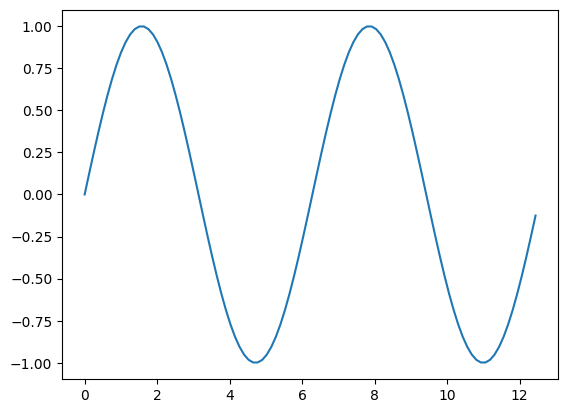

In [18]:
cycles = 2  # numero de periodos
n = 100     # numero de datos en x

length = 2 * np.pi * cycles # longitud del ciclo

# Creamos una serie de puntos
X = np.arange(0, length, length / n)
y = np.sin(X)

# Ploteamos
plt.plot(X, y, '-')

print(X.shape)
print(y.shape)

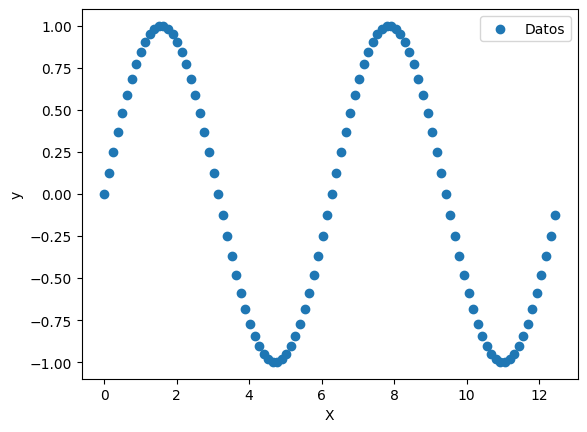

In [19]:
plt.scatter(X, y, label = "Datos")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

### Modelo de regresión

Ajustamos modelo de regresión para estos datos.

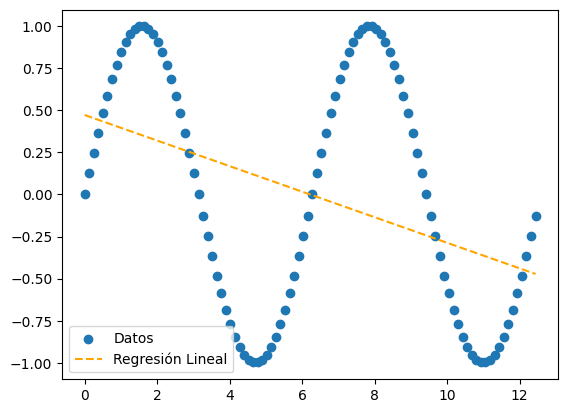

In [20]:
# Modelo de regresión
lr = LinearRegression()
X = X.reshape(-1, 1)
lr.fit(X, y)

X_range = np.arange(0, length, length / n)[:, np.newaxis] # Creamos un array de un rango de valores de dos dimensiones que es lo que espera Skitlearn
y_linear = lr.predict(X_range)

# Plot de la regresión

plt.scatter(X, y, label="Datos")
plt.plot(X_range, y_linear, label="Regresión Lineal", linestyle="--", color="orange")
plt.legend()
plt.show()

Al ser una función no lineal la regresión lineal es incapaz de predecir correctamente los datos. Por ellos vamos a utilizar una red neuronal.

### Normalizamos las variables

In [21]:
# Normalizamos X e y
x_mean, x_std = X.mean(), X.std()
y_mean, y_std = y.mean(), y.std()

X_norm = (X - x_mean) / x_std
y_norm = (y - y_mean) / y_std

# Pasamos las variables a tensores
tensor_X = torch.Tensor(X_norm)
tensor_y = torch.Tensor(y_norm)

# Creamos el dataset y el dataloader
my_dataset = TensorDataset(tensor_X,tensor_y)
my_dataloader = DataLoader(my_dataset, batch_size=16, shuffle=True) # Ponemos un batch de 16

### Red neuronal

Para captar las relaciones no lineales de estos datos necesitamos más neuronas y utilizar una funcion de activación de seno.

In [22]:
# Probamos con una forma diferrente de construir la red neuronal

class MLP(torch.nn.Module):
    def __init__(self, X_nvars):
        super().__init__()

        # Capas y función de sumatorio
        self.hidden1 = torch.nn.Linear(X_nvars, 200)
        self.hidden2 = torch.nn.Linear(200, 100)
        self.hidden3 = torch.nn.Linear(100, 50)
        self.hidden4 = torch.nn.Linear(50, 20)
        self.output = torch.nn.Linear(20, 1)

    def forward(self, x):

        # Capas y función de activación
        x = torch.sin(self.hidden1(x))  # Aplicamos la función seno
        x = torch.sin(self.hidden2(x))
        x = torch.sin(self.hidden3(x))
        x = torch.sin(self.hidden4(x))
        x = self.output(x)  #  Capa final sin activación
        return x

### Modelo

In [23]:
# Fijamos la semilla a un valor para que los resultados sean identicos
torch.manual_seed(1)

# Creamos el modelo MLP
model = MLP(X_nvars=1)

# Definimos la función loss
loss_fn = torch.nn.MSELoss()

# Elegimos el algoritmo de optimización y la tasa de aprendizaje.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

### Entrenamiento


In [24]:
# Fijamos el número de épocas o iteraciones
num_epochs = 200

# Una variables donde vamos a ir guardando los valores del loss para ploterarlos
loss_history = []

for epoch in range(num_epochs):
    model = model.train() # Instanciamos el modelo en modo entrenamiento.

    for batch_idx, (features, targets) in enumerate(my_dataloader):

        output = model(features)    # Hacemos el forward
        loss = loss_fn(output, targets.view(-1, 1))   # Calculamos el loss y cambiamos la dimensión ya que que no podemos hacer broadcasting ya que batch > 1

        optimizer.zero_grad()        # Ponemos a cero el gradiente
        loss.backward()              # Calculamos los gradientes (la derivada del loss)
        optimizer.step()             # Cambiamos los pesos de la red

        # Cada cierto tiempo vamos a imprimir un poco de información
        if not batch_idx % 100:
            print(
                f" Epoch: {epoch+1:03d}/{num_epochs:03d}"
                f" | Train Loss: {loss.item():.3f}"
            )

     # añadimos el loss a loss_history
    loss_history.append(loss.item())

 Epoch: 001/200 | Train Loss: 1.212
 Epoch: 002/200 | Train Loss: 1.021
 Epoch: 003/200 | Train Loss: 1.216
 Epoch: 004/200 | Train Loss: 0.952
 Epoch: 005/200 | Train Loss: 0.622
 Epoch: 006/200 | Train Loss: 0.774
 Epoch: 007/200 | Train Loss: 1.240
 Epoch: 008/200 | Train Loss: 0.821
 Epoch: 009/200 | Train Loss: 0.872
 Epoch: 010/200 | Train Loss: 1.010
 Epoch: 011/200 | Train Loss: 1.021
 Epoch: 012/200 | Train Loss: 0.728
 Epoch: 013/200 | Train Loss: 0.637
 Epoch: 014/200 | Train Loss: 0.606
 Epoch: 015/200 | Train Loss: 0.559
 Epoch: 016/200 | Train Loss: 0.890
 Epoch: 017/200 | Train Loss: 1.132
 Epoch: 018/200 | Train Loss: 0.766
 Epoch: 019/200 | Train Loss: 0.815
 Epoch: 020/200 | Train Loss: 0.775
 Epoch: 021/200 | Train Loss: 0.831
 Epoch: 022/200 | Train Loss: 0.891
 Epoch: 023/200 | Train Loss: 0.463
 Epoch: 024/200 | Train Loss: 0.609
 Epoch: 025/200 | Train Loss: 0.876
 Epoch: 026/200 | Train Loss: 0.492
 Epoch: 027/200 | Train Loss: 0.550
 Epoch: 028/200 | Train Loss

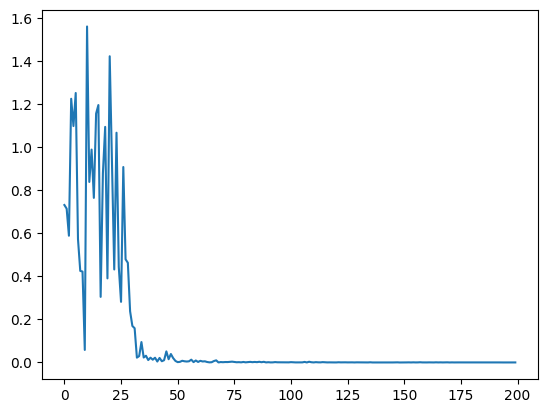

In [25]:
plt.plot(loss_history)

### Evaluación

In [26]:
model.eval() # Instanciamos el modelo en modo evaluación

# Predecimos los valores del rango X_range segun el MLP

# Se pasan a un tensor normalizado
X_range_norm = (X_range - x_mean) / x_std
X_range_norm = torch.tensor(X_range_norm, dtype=torch.float32)

# Se meten en el modelo
y_mlp_norm = model(X_range_norm)

# Ahora se desnormalizan para que estén en la misma escala
y_mlp_norm = y_mlp_norm.detach().numpy().astype(np.float64) # dejan de ser un tensor
y_mlp = y_mlp_norm * y_std + y_mean # desnormalizan


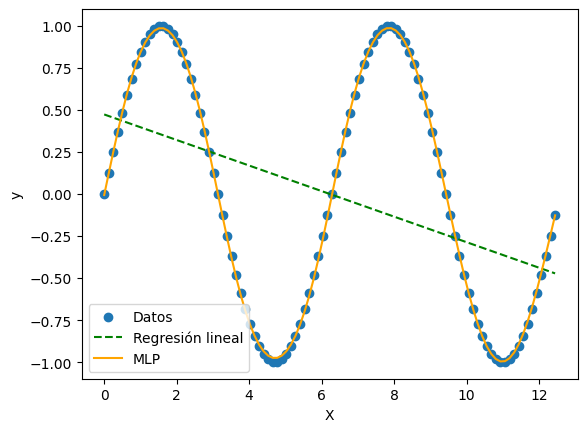

In [27]:
# Vamos a hacer un plot con los resultados

# Los datos originales
plt.scatter(X, y, label="Datos")

# Los datos predichos por la regresion lineal
plt.plot(X_range, y_linear, label="Regresión lineal", linestyle="--", color='green')

# Los datos predichos por el MLP
plt.plot(X_range, y_mlp, label="MLP", color='orange')

plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()


## 3. Entrenamiento con base de datos

Vamos a utilizar una base de datos de la felicidad de las personas. Utilizaremos como entrada todas las variables continuas de la base de datos para predecir la base calidad de vida de las personas (life ladder).


### Preparación de la base de datos y visualización

Importamos la base de datos y la limpiamos de NAs

In [28]:
# Funciones para importar y preparar los datos

import pandas as pd
url = 'https://raw.githubusercontent.com/mcstllns/UNIR2024/main/data-happiness.csv'
data  = pd.read_csv(url)
print(data.keys())
data.head()

Index(['year', 'Life.Ladder', 'Log.GDP.per.capita', 'Social.support',
       'Healthy.life.expectancy.at.birth', 'Freedom.to.make.life.choices',
       'Generosity', 'Perceptions.of.corruption', 'Positive.affect',
       'Negative.affect'],
      dtype='object')


,year,Life.Ladder,Log.GDP.per.capita,Social.support,Healthy.life.expectancy.at.birth,Freedom.to.make.life.choices,Generosity,Perceptions.of.corruption,Positive.affect,Negative.affect
0,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258
1,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237
2,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275
3,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267
4,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268


Vemos los descriptivos de la base de datos

In [29]:
data.describe()

,year,Life.Ladder,Log.GDP.per.capita,Social.support,Healthy.life.expectancy.at.birth,Freedom.to.make.life.choices,Generosity,Perceptions.of.corruption,Positive.affect,Negative.affect
count,1949.000000,1949.000000,1913.000000,1936.000000,1894.000000,1917.000000,1860.000000,1839.000000,1927.000000,1933.000000
mean,2013.216008,5.466705,9.368453,0.812552,63.359374,0.742558,0.000103,0.747125,0.710003,0.268544
std,4.166828,1.115711,1.154084,0.118482,7.510245,0.142093,0.162215,0.186789,0.107100,0.085168
min,2005.000000,2.375000,6.635000,0.290000,32.300000,0.258000,-0.335000,0.035000,0.322000,0.083000
25%,2010.000000,4.640000,8.464000,0.749750,58.685000,0.647000,-0.113000,0.690000,0.625500,0.206000
50%,2013.000000,5.386000,9.460000,0.835500,65.200000,0.763000,-0.025500,0.802000,0.722000,0.258000
75%,2017.000000,6.283000,10.353000,0.905000,68.590000,0.856000,0.091000,0.872000,0.799000,0.320000
max,2020.000000,8.019000,11.648000,0.987000,77.100000,0.985000,0.698000,0.983000,0.944000,0.705000


Vemos los outliers

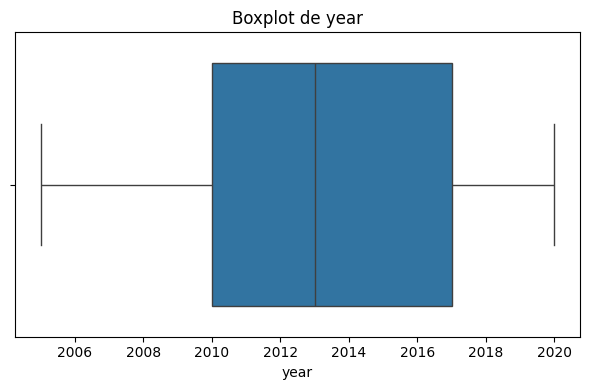

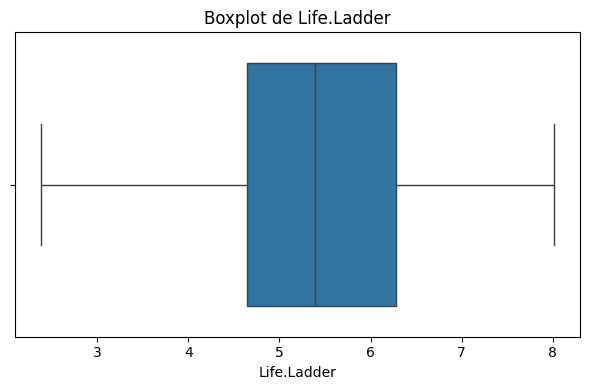

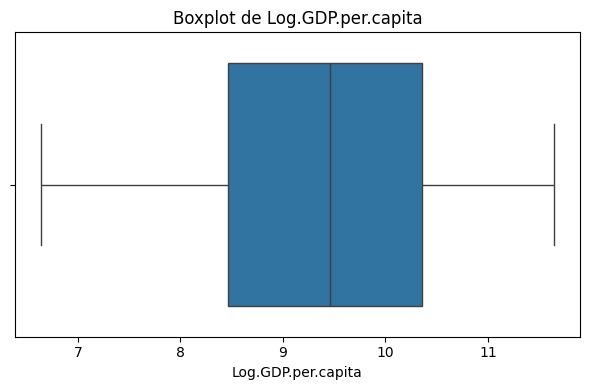

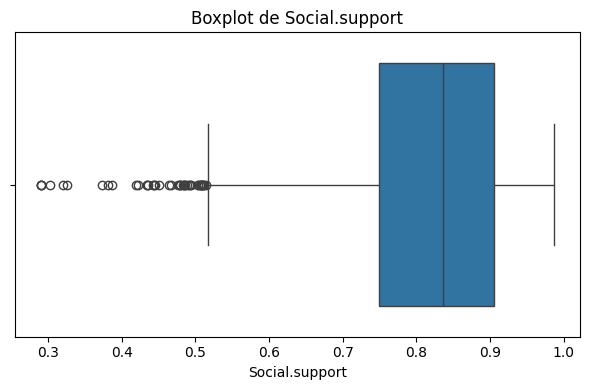

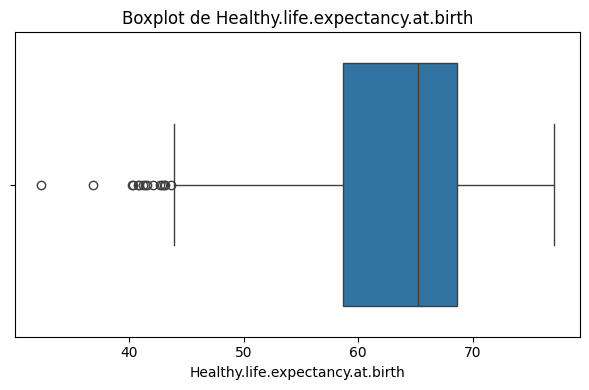

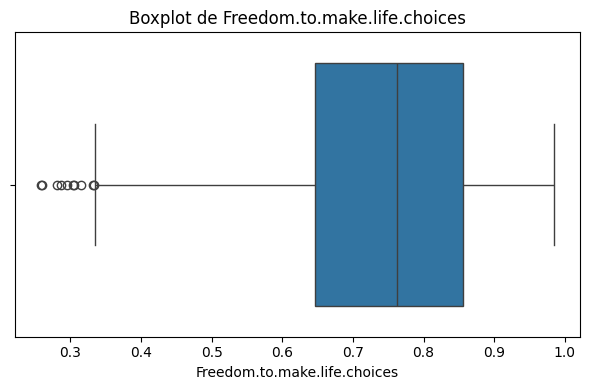

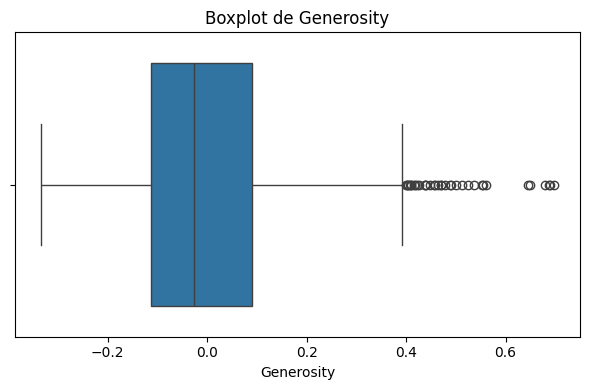

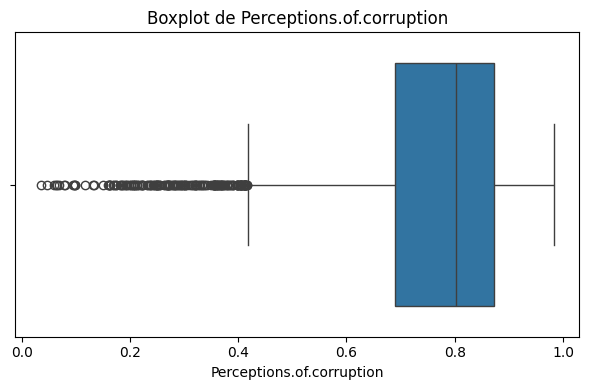

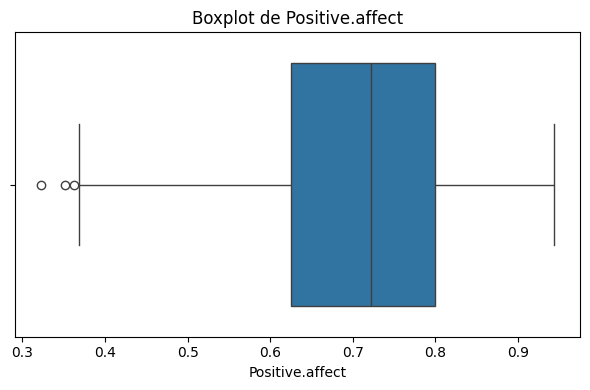

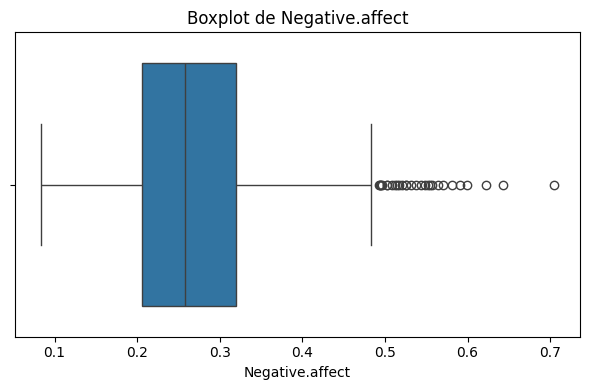

In [30]:
outlier = data.select_dtypes(include=['int64', 'float64']).columns

for col in outlier:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot de {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

Vemos que muchas variables tienen una enorme cantidad de outliers. Esto puede tener ciertos efectos en el modelo de red neuronal: Inestabilidad del entrenamiento, sesgo en la función de error hacia los outliners y peor generalización.

Contamos el número de NAs

In [31]:
print(data.isna().sum().sum())

373


Eliminamos los NAs y quitamos los años de los datos que vamos a usar par el modelo.

In [32]:
# El fichero tiene datos perdidos y hay que eliminar las filas
data = data.dropna()

# Creamos conjuntos X e y
X = data.drop('Life.Ladder', axis=1)
y = data['Life.Ladder']

print(X.head())
print(y.head())

   year  Log.GDP.per.capita  Social.support  Healthy.life.expectancy.at.birth  \
0  2008               7.370           0.451                             50.80   
1  2009               7.540           0.552                             51.20   
2  2010               7.647           0.539                             51.60   
3  2011               7.620           0.521                             51.92   
4  2012               7.705           0.521                             52.24   

   Freedom.to.make.life.choices  Generosity  Perceptions.of.corruption  \
0                         0.718       0.168                      0.882   
1                         0.679       0.190                      0.850   
2                         0.600       0.121                      0.707   
3                         0.496       0.162                      0.731   
4                         0.531       0.236                      0.776   

   Positive.affect  Negative.affect  
0            0.518            

### Preparamos los datos

Dividimos los datos en subcojuntos de entrenamiento y evaluación

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

Normalizamos los dos conjuntos. El conjunto de test utiliza las medias y la desviación timpica del conjunto de entrenamiento.

In [34]:
# Normalizamos X
x_mean, x_std = X_train.mean(), X_train.std()
y_mean, y_std = y_train.mean(), y_train.std()

# Normalizamos ambos conjuntos con las estadísticas del entrenamiento
X_train_norm = (X_train - x_mean) / x_std
X_test_norm  = (X_test - x_mean) / x_std

y_train_norm = (y_train - y_mean) / y_std
y_test_norm  = (y_test - y_mean) / y_std

Convertimos las variables en tensores

In [35]:
# Pasamos las variables a tensores
tensor_X_train = torch.from_numpy(X_train_norm.values).float()
tensor_y_train = torch.from_numpy(y_train_norm.values).float()

tensor_X_test = torch.from_numpy(X_test_norm.values).float()
tensor_y_test = torch.from_numpy(y_test_norm.values).float()

In [36]:
print("Tensor X_train",tensor_X_train.shape)
print("Tensor y_train",tensor_y_train.shape)
print("Tensor X_test",tensor_X_test.shape)
print("Tensor y_test",tensor_y_test.shape)

Tensor X_train torch.Size([1366, 9])
Tensor y_train torch.Size([1366])
Tensor X_test torch.Size([342, 9])
Tensor y_test torch.Size([342])


Creamos los dataset

In [37]:
# Dataset de entrenamiento y test
train_dataset = TensorDataset(tensor_X_train, tensor_y_train)
test_dataset = TensorDataset(tensor_X_test, tensor_y_test)

Creamos los dataloader

In [38]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Red Neuronal

Usaremos la función de activación LeakyReLU. La cual a diferencia de la ReLU permite que existan valores negativos.

In [39]:
class MLP(torch.nn.Module):
    def __init__(self, X_nvars):
        super().__init__()

        self.layers = torch.nn.Sequential(

            # Hidden Layer 1
            torch.nn.Linear(X_nvars, 300), # Hacemos el sumatorio
            torch.nn.LeakyReLU(),              # Aplicamos la función de activacion

            # Hidden Layer 2

            torch.nn.Linear(300, 100), # Hacemos el sumatorio
            torch.nn.LeakyReLU(),              # Aplicamos la función de activacion

            # Hidden Layer 3

            torch.nn.Linear(100, 50), # Hacemos el sumatorio
            torch.nn.LeakyReLU(),              # Aplicamos la función de activacion


            torch.nn.Linear(50, 20), # Hacemos el sumatorio
            torch.nn.LeakyReLU(),              # Aplicamos la función de activacion


            # output layer
            torch.nn.Linear(20, 1),
        )

    def forward(self, x):
        output = self.layers(x)
        return output

### Modelo

In [40]:
# Fijamos la semilla a un valor para que los resultados sean identicos
torch.manual_seed(1)

# Creamos el modelo MLP
model = MLP(X_nvars=9)

# Definimos la función loss
loss_fn = torch.nn.MSELoss()

# Elegimos el optimizador y el hiperparámetro de la tasa de aprendizaje
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

### Entrenamiento

In [41]:
# Fijamos el número de épocas o iteraciones
num_epochs = 200

# Lista para guardar la evolución del MSE
loss_history = []

for epoch in range(1, num_epochs + 1):
    model.train()  # Ponemos el modelo en modo entrenamiento

    total_loss = 0  # Inicializamos la pérdida acumulada

    # Iteramos por los batches de datos
    for batch_idx, (features, targets) in enumerate(train_loader):

        output = model(features)  # Forward (predicción)
        loss = loss_fn(output, targets.view(-1,1))  # Calculamos el MSE

        optimizer.zero_grad()  # Ponemos a cero el gradiente
        loss.backward()  # Calculamos los gradientes
        optimizer.step()  # Actualizamos los pesos

        total_loss += loss.item()  # Acumulamos la pérdida total

    # Calculamos el MSE promedio en esta época de entre todos los batches.
    mse_epoch = total_loss / len(train_loader)
    loss_history.append(mse_epoch)
    print(
        f"Epoch: {epoch:03d}/{num_epochs:03d}"
        f" | Train Loss: {loss.item():.3f}")

Epoch: 001/200 | Train Loss: 0.965
Epoch: 002/200 | Train Loss: 1.209
Epoch: 003/200 | Train Loss: 1.318
Epoch: 004/200 | Train Loss: 1.041
Epoch: 005/200 | Train Loss: 0.983
Epoch: 006/200 | Train Loss: 0.967
Epoch: 007/200 | Train Loss: 0.815
Epoch: 008/200 | Train Loss: 0.752
Epoch: 009/200 | Train Loss: 0.721
Epoch: 010/200 | Train Loss: 1.252
Epoch: 011/200 | Train Loss: 1.225
Epoch: 012/200 | Train Loss: 0.527
Epoch: 013/200 | Train Loss: 0.630
Epoch: 014/200 | Train Loss: 1.087
Epoch: 015/200 | Train Loss: 0.949
Epoch: 016/200 | Train Loss: 0.638
Epoch: 017/200 | Train Loss: 0.722
Epoch: 018/200 | Train Loss: 0.597
Epoch: 019/200 | Train Loss: 0.547
Epoch: 020/200 | Train Loss: 0.405
Epoch: 021/200 | Train Loss: 0.426
Epoch: 022/200 | Train Loss: 0.183
Epoch: 023/200 | Train Loss: 0.332
Epoch: 024/200 | Train Loss: 0.362
Epoch: 025/200 | Train Loss: 0.223
Epoch: 026/200 | Train Loss: 0.202
Epoch: 027/200 | Train Loss: 0.379
Epoch: 028/200 | Train Loss: 0.143
Epoch: 029/200 | Tra

### Evaluamos el modelo

#### Gráfica de la función de perdida.

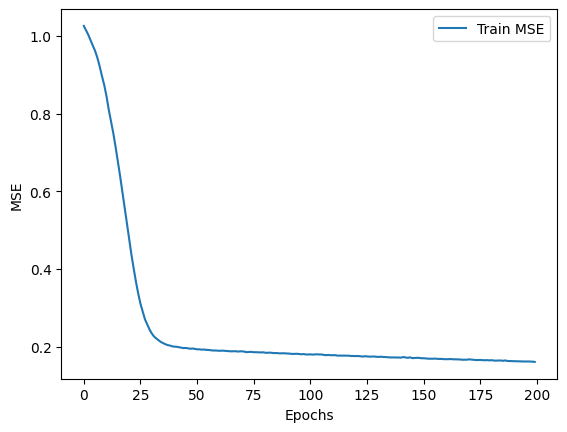

In [42]:
plt.plot(loss_history, label="Train MSE")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()

Esta gráfica es un poco engañosa por la escala. Si nos fijamos en los ejes, en realidad, no hay una cambio muy grande en la función de pérdida a lo largo de todas las épocas.

#### El error cuadrático medio

In [43]:
from sklearn.metrics import mean_squared_error, r2_score

model.eval()
test_loss = 0

y_test_preds = []
y_test_targets = []

y_train_preds = []
y_train_targets = []

with torch.no_grad():
    for features, targets in test_loader:
        output = model(features)
        loss = loss_fn(output, targets.view(-1,1))
        test_loss += loss.item()

        y_test_preds.extend(output.squeeze().tolist())
        y_test_targets.extend(targets.squeeze().tolist())

    for features, targets in train_loader:
        output = model(features)

        y_train_preds.extend(output.squeeze().tolist())
        y_train_targets.extend(targets.squeeze().tolist())


# MSE en escala normalizada
mse_test = test_loss / len(test_loader)

# Convertimos a arrays
y_test_preds = np.array(y_test_preds)
y_test_targets = np.array(y_test_targets)
y_train_preds = np.array(y_train_preds)
y_train_targets = np.array(y_train_targets)

# Desnormalizamos
y_test_preds_original = y_test_preds * y_std + y_mean
y_test_targets_original = y_test_targets * y_std + y_mean
y_train_preds_original = y_train_preds * y_std + y_mean
y_train_targets_original = y_train_targets * y_std + y_mean

# Métricas en escala original
mse_test_original_test = mean_squared_error(y_test_targets_original, y_test_preds_original)
mse_train_original_test = mean_squared_error(y_train_targets_original, y_train_preds_original)
r2_test_original_test = r2_score(y_test_targets_original, y_test_preds_original)
r2_train_original_test = r2_score(y_train_targets_original, y_train_preds_original)

# Imprimimos todo
print(
    f"Epoch: {epoch:03d}/{num_epochs:03d} | "
    f"Train MSE (norm): {mse_epoch:.4f} | Test MSE (norm): {mse_test:.4f}"
)
print(
    f"Test MSE (original): {mse_test_original_test:.4f} |  Test R² (original): {r2_test_original_test:.4f}"
)

print(
    f"Train MSE (original): {mse_train_original_test:.4f} |  Train R² (original): {r2_train_original_test:.4f}"
)


Epoch: 200/200 | Train MSE (norm): 0.1613 | Test MSE (norm): 0.1727
Test MSE (original): 0.2197 |  Test R² (original): 0.8237
Train MSE (original): 0.2104 |  Train R² (original): 0.8385


#### Gráfico de dispersión de predicciones vs valores reales

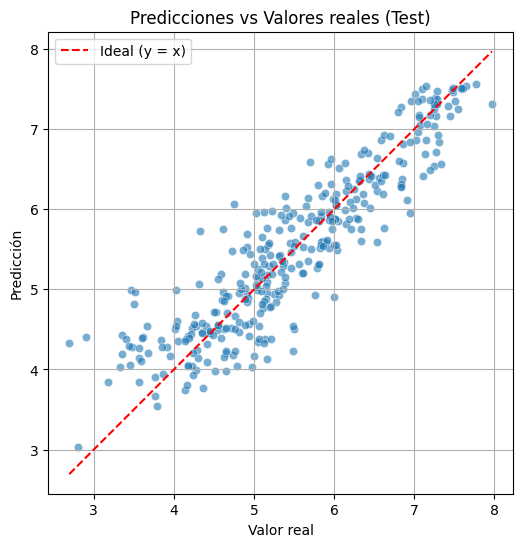

In [44]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test_targets_original, y=y_test_preds_original, alpha=0.6)
plt.plot([min(y_test_targets_original), max(y_test_targets_original)],
         [min(y_test_targets_original), max(y_test_targets_original)],
         color='red', linestyle='--', label='Ideal (y = x)')
plt.xlabel('Valor real')
plt.ylabel('Predicción')
plt.title('Predicciones vs Valores reales (Test)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

Con esta gráfica podemos ver que el modelo esta prediciendo correctamente. Parece que las predicciones del modelo estan cerca de los valores reales, se agrupan sobre la diagonal.

#### Distribución de residuos

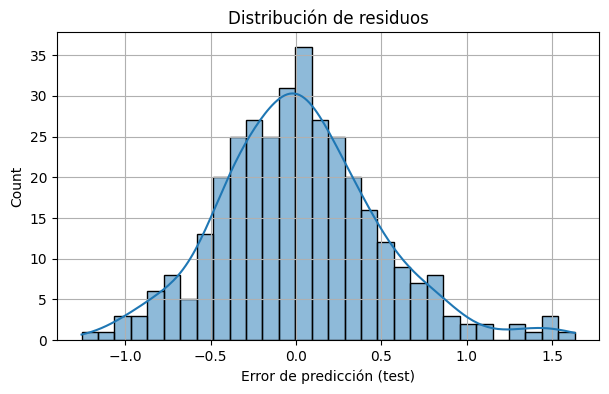

In [45]:
errores_test = y_test_preds_original - y_test_targets_original

plt.figure(figsize=(7,4))
sns.histplot(errores_test, bins=30, kde=True)
plt.xlabel('Error de predicción (test)')
plt.title('Distribución de residuos')
plt.grid(True)
plt.show()

Los residuos siguen una distribución normal lo que indica que los errores no son sistemáticos. Solo hay un pequeña tendencia con los valores más altos, parece que el modelo los infravalora. Esto puede deberse a que haya una menor cantidad de estos y el modelo no puede captar las relaciones en esta parte de la distribución.

#### Boxplot de los residuos test

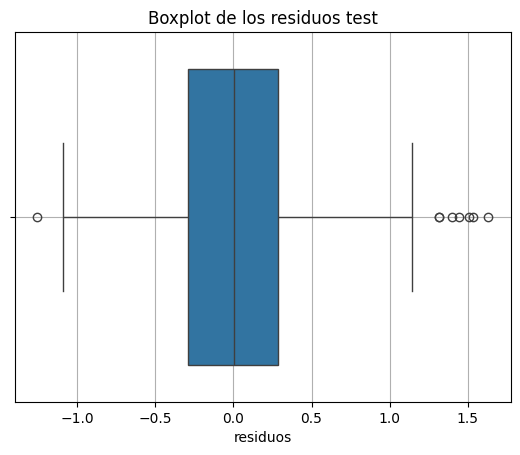

In [46]:
sns.boxplot(x=errores_test)
plt.title("Boxplot de los residuos test")
plt.xlabel("residuos")
plt.grid(True)
plt.show()

Este gráfico nos complementa el anterior.

#### Predecimos directamente un valor

Utilizamos los inputs del primer valor del dataframe.

In [69]:
valores_input = [2008 ,7.370, 0.451, 50.80, 0.718, 0.168, 0.882, 0.518, 0.258]

In [70]:
columnas_features = ['year',
    'Log.GDP.per.capita',
    'Social.support',
    'Healthy.life.expectancy.at.birth',
    'Freedom.to.make.life.choices',
    'Generosity',
    'Perceptions.of.corruption',
    'Positive.affect',
    'Negative.affect'
]

In [71]:
x_mean = np.array([X_train[col].mean() for col in columnas_features])
x_std = np.array([X_train[col].std() for col in columnas_features])

# Normalización
valores_norm = (np.array(valores_input) - x_mean) / x_std

In [72]:
# Convierte a tensor y añade dimensión de batch
input_tensor = torch.tensor(valores_norm, dtype=torch.float32).unsqueeze(0)

# Predicción
model.eval()
with torch.no_grad():
    salida_norm = model(input_tensor).item()

# Desnormaliza la salida (Life.Ladder)
pred_life_ladder = salida_norm * y_std + y_mean

print(f"Predicción de Life.Ladder: {pred_life_ladder:.3f}")


Predicción de Life.Ladder: 3.869


In [73]:
data.head()

,year,Life.Ladder,Log.GDP.per.capita,Social.support,Healthy.life.expectancy.at.birth,Freedom.to.make.life.choices,Generosity,Perceptions.of.corruption,Positive.affect,Negative.affect
0,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258
1,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237
2,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275
3,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267
4,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268


Vemos que la predicción de la red ha sido 3.869 mientras que el valor real ha sido 3.724. Bastante cercano el valor

### Comparamos la predicción del modelo con un modelo de regresión lineal

In [47]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

r2_lr_model = r2_score(y_test, y_pred_lr)
print(f"R² modelo de regresión: {r2_lr_model:.4f}")

R² modelo de regresión: 0.7513


In [48]:
model.eval()
with torch.no_grad():
    y_pred_nn_norm = model(torch.tensor(X_test_norm.values, dtype=torch.float32)).numpy()

    y_pred_nn_real = y_pred_nn_norm * y_std + y_mean

    r2_nn = r2_score(y_test, y_pred_nn_real)
    print(f"R² modelo de red neuronal: {r2_nn:.4f}")


R² modelo de red neuronal: 0.8237


### Modelo de regresión lineal

In [54]:
import statsmodels.api as sm

x = sm.add_constant(X)  # Agregar constante (intercepto)
modelo = sm.OLS(y, x).fit()

print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:            Life.Ladder   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     640.7
Date:                Mon, 14 Jul 2025   Prob (F-statistic):               0.00
Time:                        14:21:19   Log-Likelihood:                -1377.2
No. Observations:                1708   AIC:                             2774.
Df Residuals:                    1698   BIC:                             2829.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

### Evaluamos los supuestos del modelo de regresión lineal

#### 1. Supuesto de linealidad.

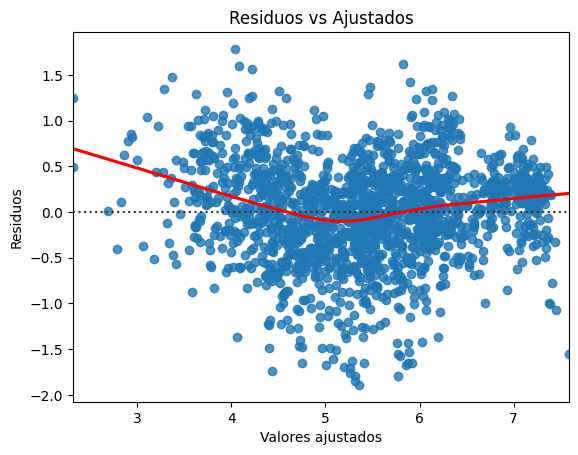

In [57]:
# Predicciones y residuos
residuos = modelo.resid
fitted = modelo.fittedvalues

# Gráfico
sns.residplot(x=fitted, y=residuos, lowess=True, line_kws={"color": "red"})
plt.xlabel("Valores ajustados")
plt.ylabel("Residuos")
plt.title("Residuos vs Ajustados")
plt.show()

Con este gráfico vemos que la línea roja tiene una forma parcialmente de U lo que violaría el principio de linealidad.

#### 2. Independencia de los errores

In [55]:
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:            Life.Ladder   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     640.7
Date:                Mon, 14 Jul 2025   Prob (F-statistic):               0.00
Time:                        14:24:31   Log-Likelihood:                -1377.2
No. Observations:                1708   AIC:                             2774.
Df Residuals:                    1698   BIC:                             2829.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

Según el valor de Durbin Watson vemos una autocorrelación preocupante entre los errores.

#### 3. Homocedasticidad (varianza constante de los errores)

In [58]:
from statsmodels.stats.diagnostic import het_breuschpagan

test = het_breuschpagan(modelo.resid, modelo.model.exog)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, test)))

{'Lagrange multiplier statistic': np.float64(79.96503790961297), 'p-value': np.float64(1.6421822841332928e-13), 'f-value': np.float64(9.266838552968808), 'f p-value': np.float64(7.822448393669218e-14)}


El modelo viola el principio de homocedasticidad

#### 4. Normalidad de los residuos

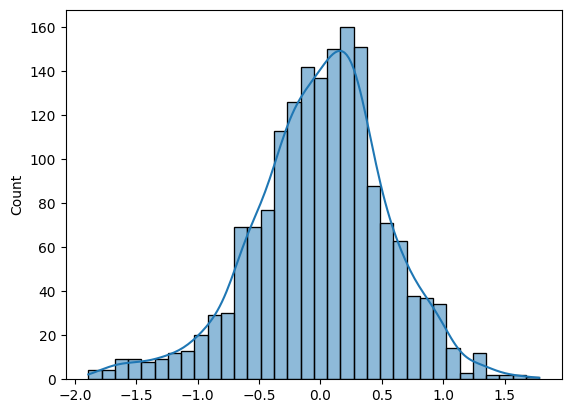

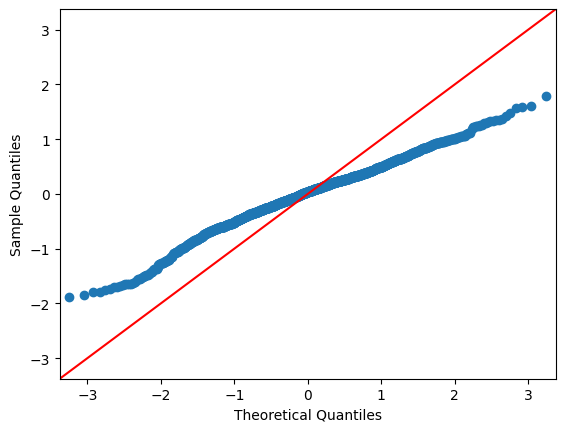

Shapiro-Wilk: p = 3.414437261135002e-10


In [59]:
# Histograma
sns.histplot(residuos, kde=True)

# Gráfico Q-Q
sm.qqplot(residuos, line='45')
plt.show()

# Prueba de Shapiro-Wilk
from scipy.stats import shapiro
shapiro_test = shapiro(residuos)
print(f"Shapiro-Wilk: p = {shapiro_test.pvalue}")

En las gráficas podemos ver que los residuos siguen más o menos una distribución normal. Pese a ello el estadístico de Shapiro-Wilk no deja ninguna duda los residuos no cumplen el supuesto de normalidad.

#### 5. Ausencia de multicolinealidad

In [60]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# DataFrame con constantes incluidas
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                            feature         VIF
0                              year  201.439604
1                Log.GDP.per.capita  329.028863
2                    Social.support  118.446087
3  Healthy.life.expectancy.at.birth  280.507130
4      Freedom.to.make.life.choices   55.944304
5                        Generosity    1.287096
6         Perceptions.of.corruption   26.613481
7                   Positive.affect   85.507273
8                   Negative.affect   15.980088


Salvo la variable generosidad todas las demás son claramente multicolineales.

### Explicación

Podemos como la red neuronal ha podido captar mejor las relaciones no lineales entre las distintas variables inputs y la variable outcome. Mientras que el modelo de regresión lineal múltiple no ha podido captar estas relaciones, lastrada por estas relaciones no lineales.

Con todo esto podemos ver la utilidad que puede tener una red neuronal desde un enfoque puramente predictivo. Sería interesante ver si el entrenamiento de la red con esta base de datos se podría generalizar a otra similar, aunque por mi propia experiencia me parece dificil que eso llegase a suceder.